In [1]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
from scipy.stats import zscore
from IPython.display import clear_output
from scipy.io import loadmat
%matplotlib inline

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import get_upsampling_indices, print_wise
from general_utils.neural_utils import face_fixations
from data_preprocessing.preprocessing import min_max_normalization
from image_processing.utils import read_video

In [2]:
#strip foreperiod_len_timepts from neural and gaze, compute fixations on faces e idx neu.l result


In [3]:
monkey_name = "venus"
npx = True
imec_n = 0
resolution_Hz = 100
foreperiod_len_timepts = 30
n_timepts_bef, n_timepts_aft = 40, 40
model_name = "human_face_detection"
days = range(19, 25)
month = "sep"
tot_face_fix, tot_non_face_fix, tot_rep_face_fix = face_fixations(paths, monkey_name, days, month, npx, imec_n, resolution_Hz, n_timepts_bef, n_timepts_aft, foreperiod_len_timepts, model_name, normalization="min_max")

19:01:36 - computed day 19 of monkey venus
19:02:05 - computed day 20 of monkey venus
19:03:08 - computed day 21 of monkey venus
19:04:01 - computed day 22 of monkey venus
19:04:30 - computed day 23 of monkey venus
19:04:56 - computed day 24 of monkey venus


In [184]:
tot_face_fix = np.concatenate(tot_face_fix, axis=2)
tot_non_face_fix = np.concatenate(tot_non_face_fix, axis=2)    
tot_rep_face_fix = np.concatenate(tot_rep_face_fix, axis=2)

(383, 80, 82)

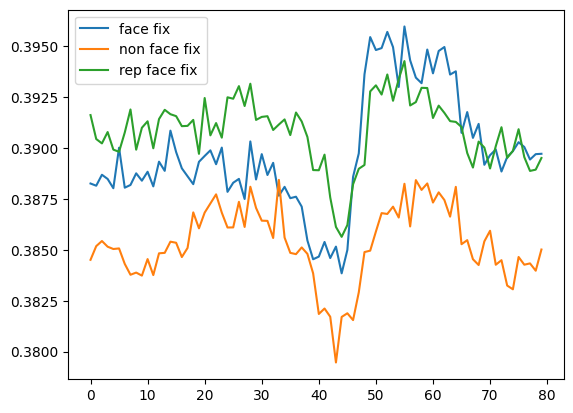

In [4]:

plt.plot(np.mean(np.mean(tot_face_fix[:140, :,:], axis=2), axis=0)) 
plt.plot(np.mean(np.mean(tot_non_face_fix[:140, :,:], axis=2), axis=0)) 
plt.plot(np.mean(np.mean(tot_rep_face_fix[:140, :,:], axis=2), axis=0)) 
plt.legend(["face fix", "non face fix", "rep face fix"])

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
#from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

face_fix_idx = np.ones(tot_face_fix.shape[2])
no_face_fix_idx = np.zeros(tot_non_face_fix.shape[2])[:tot_face_fix.shape[2]]
y = np.concatenate((no_face_fix_idx, face_fix_idx))
x_timeseries = np.concatenate((tot_non_face_fix, tot_face_fix),axis=2)

acc_list_f_non_f = []
st_idx = 0
end_idx = 50
n_splits = 10
for i in range(x_timeseries.shape[1]):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) 
    acc_list_at_t = []
    x = x_timeseries[st_idx:end_idx, i, :].T
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
    # Split into training and testing sets
    #X_train, X_test, y_train, y_test = train_test_split(x_timeseries[st_idx:end_idx,i,:].T, y, test_size=0.2, shuffle=True, random_state=42) # understand what are thos kwargs

    # Initialize the model
        model = LogisticRegression(max_iter=1000)

    # Train the model
        model.fit(x_train, y_train)

    # Make predictions
        y_pred = model.predict(x_test)
    # Evaluate
        acc_list_at_t.append(accuracy_score(y_test, y_pred))
    avg_acc = np.mean(acc_list_at_t)
    acc_list_f_non_f.append(avg_acc)
    # print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    #print("Classification Report:\n", classification_report(y_test, y_pred))

In [95]:
def plot_accuracy_response(acc_list, tot_face_fix, tot_non_face_fix,  n_timepts_bef, n_timepts_aft, resolution_Hz):
    time_axis = np.arange(-n_timepts_bef, n_timepts_aft) * (1000 / resolution_Hz)
    fig, ax1 = plt.subplots(figsize=(8, 4))

    # ---- Left y-axis (accuracy)
    ax1.plot(time_axis, acc_list, marker=".", color="blue", label="Classification accuracy", linewidth=2)
    ax1.axvline(x=0, color='r', linestyle='--', linewidth=1)
    ax1.axhline(y=0.5, color='r', linestyle='-', linewidth=2, label="Chance")
    ax1.set_xlabel("Time from fixation onset (ms)")
    ax1.set_ylabel("Accuracy", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    # ---- Right y-axis (neural magnitude difference)
    ax2 = ax1.twinx()
    diff_signal = np.mean((np.mean(tot_face_fix[st_idx:end_idx, :, :], axis=2) - np.mean(tot_non_face_fix[st_idx:end_idx, :, :], axis=2)).T,axis=1)
    ax2.plot(time_axis, diff_signal, color="purple", label="Response diff (mean)", linewidth=4)
    ax2.tick_params(axis='y', colors='purple')    # tick marks
    ax2.set_ylabel("Response difference", color="purple")
    ax2.tick_params(axis='y', labelcolor="purple")
    ax2.yaxis.label.set_color('purple')   
    ax2.set_ylim([-0.005, 0.025])
    # ---- Legend handling
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.set_ylim([.45, .70])
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
    ax2.spines['left'].set_color('blue') 
    ax2.spines['right'].set_color('purple')        # left axis line

    plt.title(f"Channels {st_idx} to {end_idx} - Classification accuracy and face-nonface response difference")
    plt.tight_layout()
    plt.show()

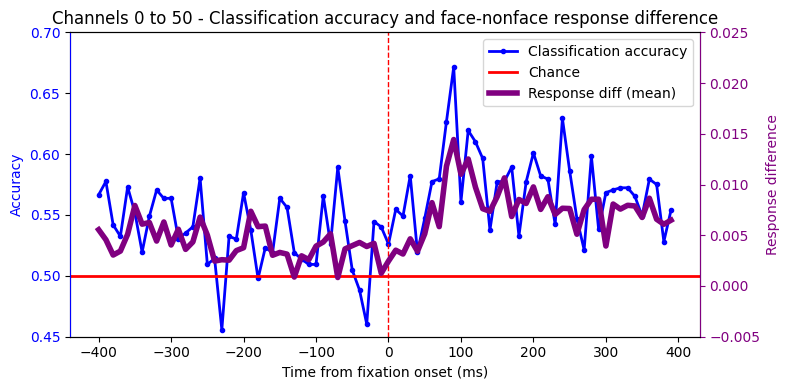

In [96]:
plot_accuracy_response(acc_list_f_non_f, tot_face_fix, tot_non_face_fix,  n_timepts_bef, n_timepts_aft, resolution_Hz)

In [15]:
tot_rep_face_fix_decoding = tot_rep_face_fix[:,:,:tot_non_face_fix.shape[2]] 
rep_face_fix_idx = np.ones(tot_rep_face_fix.shape[2])
no_face_fix_idx = np.zeros(tot_non_face_fix.shape[2])[:tot_rep_face_fix_decoding.shape[2]]
y = np.concatenate((no_face_fix_idx, rep_face_fix_idx))
x_timeseries = np.concatenate((tot_non_face_fix, tot_rep_face_fix_decoding),axis=2)
acc_list_rep = []
st_idx = 0
end_idx = 50
n_splits = 10
for i in range(x_timeseries.shape[1]):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) 
    acc_list_at_t = []
    x = x_timeseries[st_idx:end_idx, i, :].T
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
    # Split into training and testing sets
    #X_train, X_test, y_train, y_test = train_test_split(x_timeseries[st_idx:end_idx,i,:].T, y, test_size=0.2, shuffle=True, random_state=42) # understand what are thos kwargs

    # Initialize the model
        model = LogisticRegression(max_iter=1000)

    # Train the model
        model.fit(x_train, y_train)

    # Make predictions
        y_pred = model.predict(x_test)
    # Evaluate
        acc_list_at_t.append(accuracy_score(y_test, y_pred))
    avg_acc = np.mean(acc_list_at_t)
    acc_list_rep.append(avg_acc)
    # print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    #print("Classification Report:\n", classification_report(y_test, y_pred))



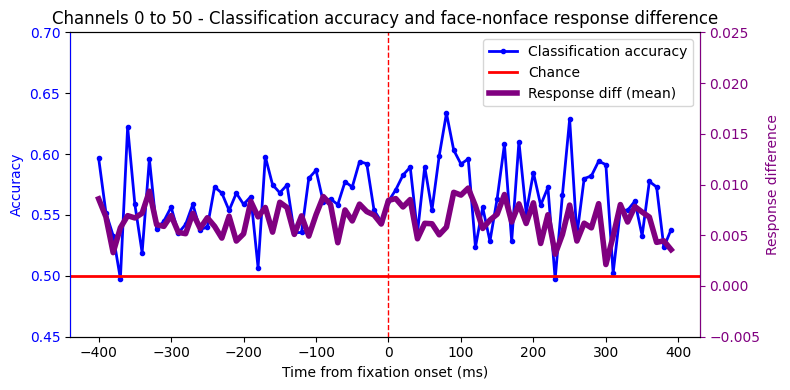

In [97]:
plot_accuracy_response(acc_list_rep, tot_rep_face_fix_decoding, tot_non_face_fix,  n_timepts_bef, n_timepts_aft, resolution_Hz)

In [90]:
from sklearn.decomposition import PCA
pca_non_faces = PCA(n_components=2)  # reduce to 2 components
pca_non_faces.fit(np.reshape(non_face_fix, (non_face_fix.shape[0], -1)).T)
pca_faces = PCA(n_components=2)  # reduce to 2 components
pca_faces.fit(np.reshape(non_face_fix, (face_fix.shape[0], -1)).T)

,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [91]:
evecs_non_face = pca_non_faces.components_
evecs_face = pca_faces.components_


In [92]:
tpts_non_faces = []
tpts_faces = []
for i in range(non_face_fix.shape[1]):
    tpts_non_faces.append(np.mean(evecs_non_face @ non_face_fix[:,i,:], axis=1))
    tpts_faces.append(np.mean(evecs_face @ face_fix[:,i,:], axis=1))

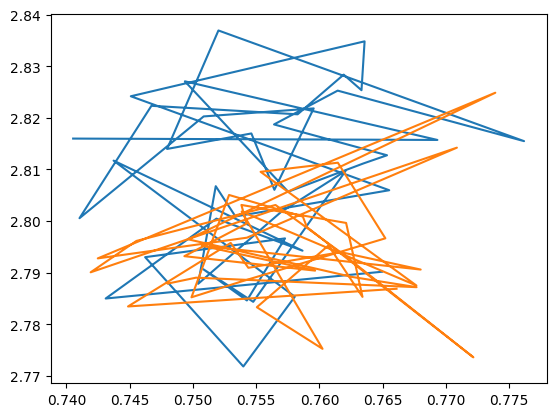

In [96]:
all_non_faces = np.stack(tpts_non_faces, axis=1)
all_faces = np.stack(tpts_faces, axis=1)
plt.plot(all_non_faces[0,:40], all_non_faces[1,:40])
plt.plot(all_faces[0,:40], all_faces[1,:40])